In [16]:
%matplotlib inline
import os
import h5py
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from mintpy.utils import writefile

work_dir = os.path.expanduser('~/development/2019_Kirishima/Shinmoedake_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/development/2019_Kirishima/Shinmoedake_model


## GBIS inversion result --> MintPy HDF5 file

delete exsited file: /Users/yunjunz/insarlab/Kirishima/Model/Shinmoedake_2008/invert_1_2_T/ShinmoedakeAlosDT73_20081012_20100302.h5
create HDF5 file: /Users/yunjunz/insarlab/Kirishima/Model/Shinmoedake_2008/invert_1_2_T/ShinmoedakeAlosDT73_20081012_20100302.h5 with w mode
create dataset /x        of float32    in size of (217, 217)           with compression=None
create dataset /y        of float32    in size of (217, 217)           with compression=None
create dataset /data     of float32    in size of (217, 217)           with compression=None
create dataset /model    of float32    in size of (217, 217)           with compression=None
create dataset /residual of float32    in size of (217, 217)           with compression=None
finished writing to /Users/yunjunz/insarlab/Kirishima/Model/Shinmoedake_2008/invert_1_2_T/ShinmoedakeAlosDT73_20081012_20100302.h5
delete exsited file: /Users/yunjunz/insarlab/Kirishima/Model/Shinmoedake_2008/invert_1_2_T/ShinmoedakeAlosAT424_20080929_20100520.h

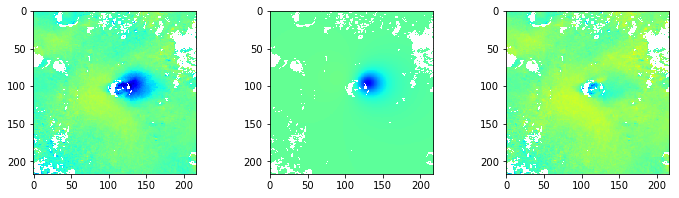

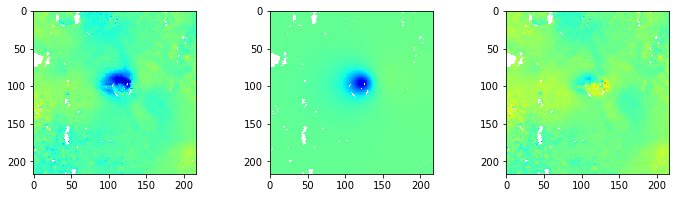

In [32]:
# read data from mat file
inv_file = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoedake_2008/invert_1_2_T/invert_1_2_T.mat')
inv = sio.loadmat(inv_file, struct_as_record=False, squeeze_me=True)

# get metadata/mask from data file
for i in range(len(inv['insar'])):
    data_file = inv['insar'][i].dataPath
    mask = sio.loadmat(data_file, struct_as_record=False, squeeze_me=True)['Mask']
    meta = vars(sio.loadmat(data_file, struct_as_record=False, squeeze_me=True)['Metadata'])
    temp = meta.pop('_fieldnames') # remote _fieldnames added by Matlab
    length, width = mask.shape
    
    # convert to 2D matrix
    insarPlot = inv['insarPlot'][i]
    x = np.zeros((length, width), dtype=np.float32) * np.nan
    y = np.zeros((length, width), dtype=np.float32) * np.nan
    data = np.zeros((length, width), dtype=np.float32) * np.nan
    model = np.zeros((length, width), dtype=np.float32) * np.nan
    residual = np.zeros((length, width), dtype=np.float32) * np.nan
    x[mask!=0] = insarPlot.xy[:,1]
    y[mask!=0] = insarPlot.xy[:,2]
    data[mask!=0] = insarPlot.data
    model[mask!=0] = insarPlot.model
    residual[mask!=0] = insarPlot.residual
    
    # write to HDF5 file
    dsDict = {}
    dsDict['x'] = x
    dsDict['y'] = y
    dsDict['data'] = data
    dsDict['model'] = model
    dsDict['residual'] = residual
    h5_filename = os.path.join(os.path.dirname(inv_file), '{}.h5'.format(insarPlot.name))
    writefile.write(dsDict, out_file=h5_filename, metadata=meta)
    
    # plot
    dlim = np.nanmax(np.abs(data))
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 3])
    axs[0].imshow(data,     vmin=-dlim, vmax=dlim, cmap='jet')
    axs[1].imshow(model,    vmin=-dlim, vmax=dlim, cmap='jet')
    axs[2].imshow(residual, vmin=-dlim, vmax=dlim, cmap='jet')
plt.show()

In [ ]:
## Figure 3 - Inversion result


